# Statistical analysis to get the significantly associated tokens for attribution score groupings for SAUR cohort

## Read mapping information

In [1]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [2]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [3]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read bed files containing overlapping tokens and attribution scores

In [4]:
import os
import pandas as pd
from pathlib import Path


overlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations', 'SAUR')

overlappingDfList = []
for overlappingFile in os.listdir(overlappingFilesDir):
    df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df['tube_code'] = [overlappingFile.split('_')[0]]*df.shape[0]
    overlappingDfList.append(df)
overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf = overlappingDf.merge(
    mappedJourneyTubeIdsDf,
    how='inner',
    on=['tube_code']
)
overlappingDf = overlappingDf.drop_duplicates()
overlappingDf = overlappingDf[overlappingDf.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
overlappingDf['gene'] = overlappingDf.gene.str.lower()
# overlappingDf = overlappingDf[overlappingDf.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
overlappingDf

/tmp/ipykernel_12974/3306788520.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
/tmp/ipykernel_12974/3306788520.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
/tmp/ipykernel_12974/3306788520.py:10: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'at

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code,person_id,JOURNEY_ID
0,1,1,193,197,ATAAC,-0.000873,CDS,CFBAKF_00005,DUF3969 domain-containing protein,NaN,ID=CFBAKF_00005;Name=DUF3969 domain-containing...,AH19E065,2221447,681015
1,4,1,204,210,ATTGATT,-0.000882,CDS,CFBAKF_00005,DUF3969 domain-containing protein,NaN,ID=CFBAKF_00005;Name=DUF3969 domain-containing...,AH19E065,2221447,681015
2,5,1,211,218,AATATTTT,0.000624,CDS,CFBAKF_00005,DUF3969 domain-containing protein,NaN,ID=CFBAKF_00005;Name=DUF3969 domain-containing...,AH19E065,2221447,681015
3,6,1,219,225,GTCATTG,-0.001691,CDS,CFBAKF_00005,DUF3969 domain-containing protein,NaN,ID=CFBAKF_00005;Name=DUF3969 domain-containing...,AH19E065,2221447,681015
4,7,1,226,233,AATTCTAC,-0.000970,CDS,CFBAKF_00005,DUF3969 domain-containing protein,NaN,ID=CFBAKF_00005;Name=DUF3969 domain-containing...,AH19E065,2221447,681015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15277499,18859790,5,205763,205769,ATGATAT,0.002546,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881
15277500,18859791,5,205770,205775,CCATCA,0.000022,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881
15277501,18859792,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881
15277502,18859793,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881


## Perform chi-square test

### Attribution score distribution

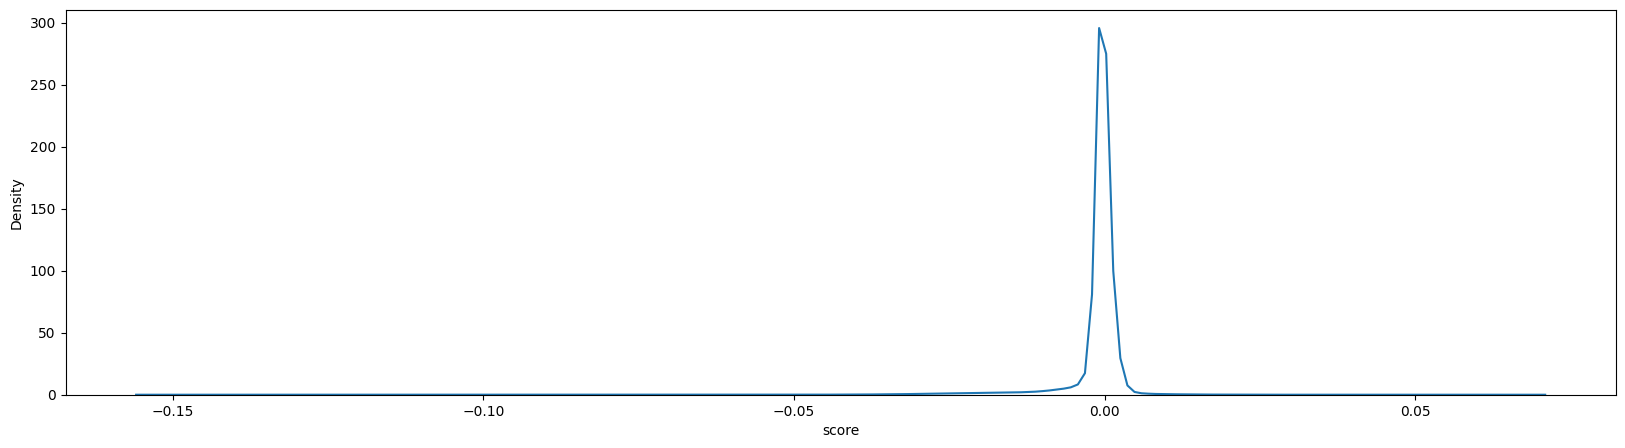

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,5))

sns.kdeplot(data=overlappingDf, x='score')

plt.show()

### Attribution score distribution (Zoomed)

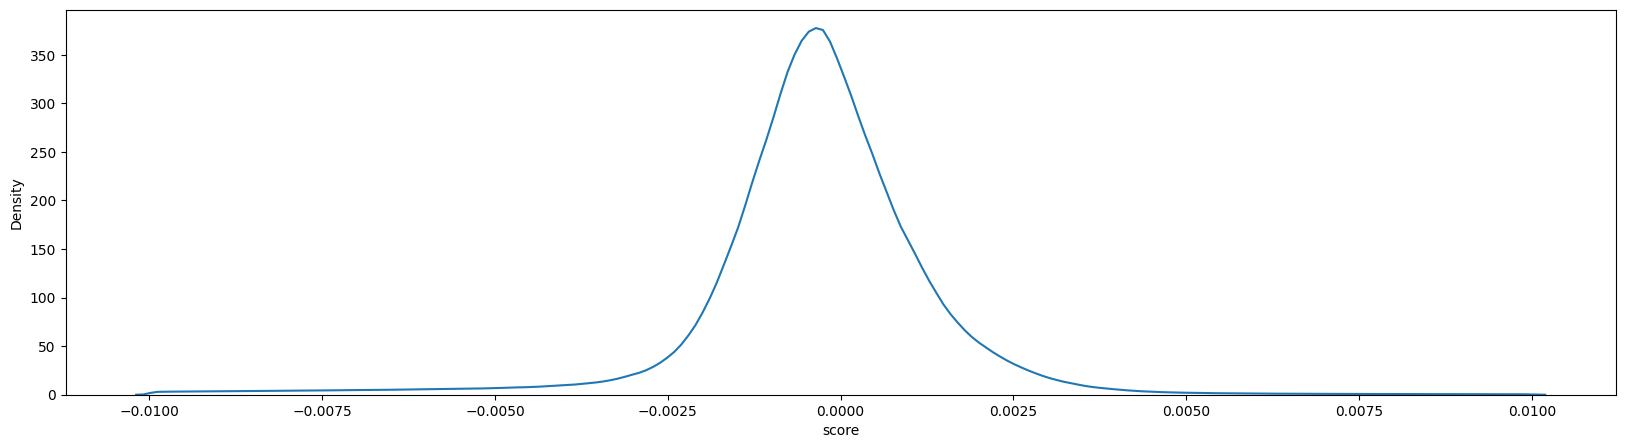

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns


plt.figure(figsize=(20,5))

sns.kdeplot(data=overlappingDf[(overlappingDf.score > -0.01) & (overlappingDf.score < 0.01)], x='score')

plt.show()

### High attribution score

In [31]:
cutoff = overlappingDf.score.mean() + 0 * overlappingDf.score.std()
cutoff

np.float64(-0.0010072603766566259)

In [32]:
from scipy import stats

highScoreOverlappingDf = overlappingDf[(overlappingDf.score > cutoff)].tokens.value_counts().reset_index()
lowScoreOverlappingDf = overlappingDf[(overlappingDf.score < cutoff)].tokens.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['tokens_hs'],
    right_on=['tokens_ls']
)[['tokens_hs', 'count_hs', 'count_ls']].rename(columns={'tokens_hs': 'tokens'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)


4941204.540709287 0.0 True


`The test indicates that the tokens associated with the high score group are significantly different than the rest`

#### Calculate the ratio of count differences

In [33]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)
filteredOverlappingDf

/tmp/ipykernel_12974/2481632118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
0,ACGAT,57339,6900,0.001590,17392.168104,3.296829
1,ATGAT,43391,26523,0.006112,66853.981829,0.649041
2,TACTT,42636,2225,0.000513,5608.344063,7.602244
3,GCAAT,41942,7293,0.001681,18382.765505,2.281594
4,ATTGC,39667,3554,0.000819,8958.226876,4.427997
...,...,...,...,...,...,...
3551,GGAGATTTCA,12,57,0.000013,143.674432,0.083522
3552,CCAGCCTGG,10,6,0.000001,15.123624,0.661217
3553,CCTGGCCA,10,16,0.000004,40.329665,0.247956
3556,CTGAGGTC,6,13,0.000003,32.767853,0.183106


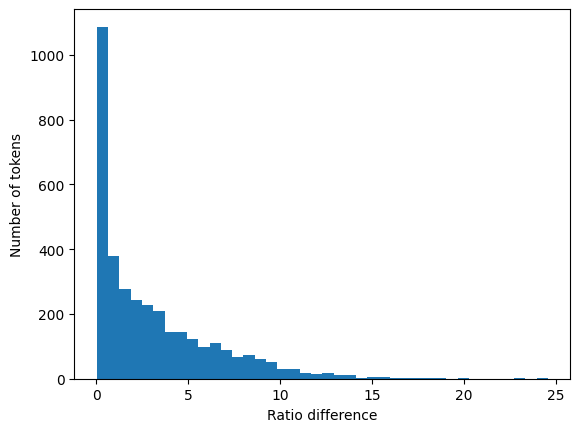

In [34]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference, bins=40)
plt.xlabel("Ratio difference")
plt.ylabel("Number of tokens")
plt.show()

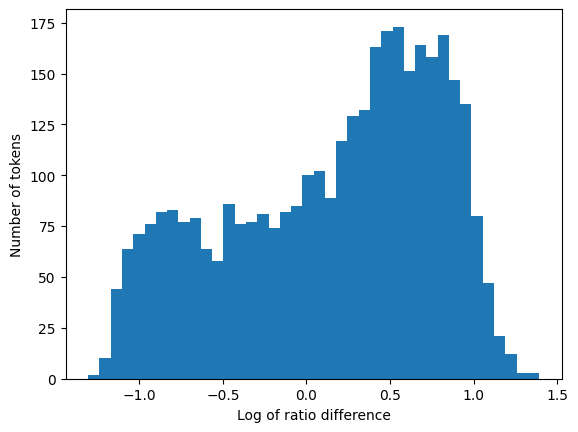

In [35]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference.apply(np.log10), bins=40)
plt.xlabel("Log of ratio difference")
plt.ylabel("Number of tokens")
plt.show()

#### Over represented tokens associated with the high attribution score

In [39]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 15]
overrepresentedTokensDf

/tmp/ipykernel_12974/769977940.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 15]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
577,ATTTCT,5152,136,0.000031,342.802154,15.029077
162,TAGTTT,10103,264,0.000061,665.439475,15.182448
559,CGCCC,5211,136,0.000031,342.802154,15.201188
310,TGGTGT,7537,196,0.000045,494.038398,15.255899
770,AGCAGCA,4250,109,0.000025,274.745844,15.468842
1205,CCAGAA,3037,77,0.000018,194.086514,15.647661
368,TACATTT,6781,171,0.000039,431.023296,15.732328
3225,TCTCCCA,278,7,0.000002,17.644229,15.755860
3131,ACACATACA,360,9,0.000002,22.685437,15.869212
2351,TGTTTTCT,1154,28,0.000006,70.576914,16.350956


#### Over represented genes associated with the high attribution score

In [20]:
tempDf = overrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
268,CDS,gcvt,glycine cleavage system aminomethyltransferase...,137
502,CDS,nif3,Nif3-like dinuclear metal center hexameric pro...,118
685,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,115
304,CDS,gyra,DNA gyrase subunit A,106
844,CDS,vals,valine--tRNA ligase,100
721,CDS,seca2,accessory Sec system translocase SecA2,92
722,CDS,secdf,protein translocase subunit SecDF,92
132,CDS,cshb,DEAD-box ATP-dependent RNA helicase CshB,91
626,CDS,qdoi,Cupin domain protein related to quercetin diox...,89
137,CDS,ctpa,putative CtpA-like serine protease,89


#### Under represented tokens associated with the high attribution score

In [29]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.07]
underrepresentedTokensDf

/tmp/ipykernel_12974/1530873054.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.07]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
3534,GTGATCTG,31,248,0.000057,625.109810,0.049591
3385,TTTCTTTTTT,143,1091,0.000251,2749.979044,0.052000
3218,CTTCTTTC,283,1912,0.000441,4819.394988,0.058721
3464,TCAGTCT,92,615,0.000142,1550.171505,0.059348
3459,TTCCTCA,92,594,0.000137,1497.238819,0.061446
3386,GTTCCC,142,904,0.000208,2278.626082,0.062318
3535,CCTGCCTT,30,183,0.000042,461.270545,0.065038
3241,CCCATG,258,1564,0.000360,3942.224770,0.065445
3363,CCTCTTC,159,957,0.000221,2412.218098,0.065914
3008,ACCTTG,481,2891,0.000666,7287.066375,0.066007


#### Under represented genes associated with the high attribution score

In [27]:
tempDf = underrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]
# gene.value_counts().reset_index()[:5]

,feature_type,gene,name,tokens
206,CDS,trpb,tryptophan synthase subunit beta,59
3,CDS,acoa,TPP-dependent pyruvate or acetoin dehydrogenas...,58
224,CDS,yhge,Uncharacterized membrane protein YhgE%2C phage...,47
89,CDS,heml,glutamate-1-semialdehyde 2%2C1-aminomutase,47
54,CDS,dnak,molecular chaperone DnaK,46
145,CDS,odha,2-oxoglutarate dehydrogenase E1 component,45
157,CDS,pola,DNA polymerase I,44
120,CDS,mnth,Mn2+ or Fe2+ transporter%2C NRAMP family,40
187,CDS,sece,preprotein translocase subunit SecE,38
139,CDS,nrdr,transcriptional regulator NrdR,38


### Low attribution score

In [40]:
cutoff = overlappingDf.score.mean() - 0 * overlappingDf.score.std()
cutoff

np.float64(-0.0010072603766566259)

In [41]:
from scipy import stats


highScoreOverlappingDf = overlappingDf[(overlappingDf.score > cutoff)].tokens.value_counts().reset_index()
lowScoreOverlappingDf = overlappingDf[(overlappingDf.score < cutoff)].tokens.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['tokens_hs'],
    right_on=['tokens_ls']
)[['tokens_hs', 'count_hs', 'count_ls']].rename(columns={'tokens_hs': 'tokens'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)


4941204.540709287 0.0 True


#### Calculate the ratio of count differences

In [42]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)

/tmp/ipykernel_12974/3361415802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)


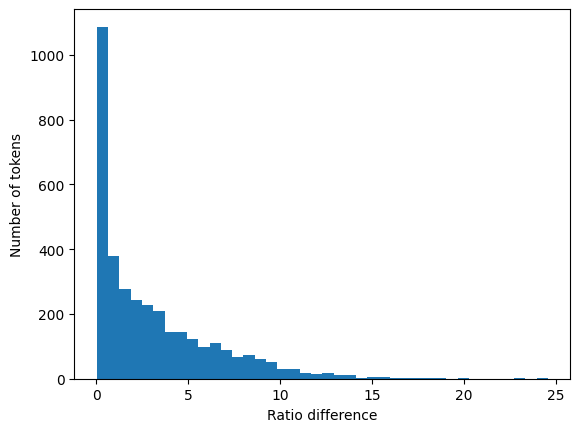

In [43]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference, bins=40)
plt.xlabel("Ratio difference")
plt.ylabel("Number of tokens")
plt.show()

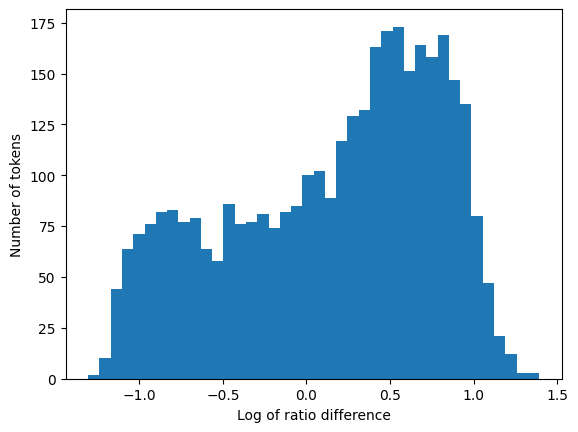

In [44]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference.apply(np.log10), bins=40)
plt.xlabel("Log of ratio difference")
plt.ylabel("Number of tokens")
plt.show()

#### Over represented tokens associated with the low attribution score

In [45]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]
overrepresentedTokensDf

/tmp/ipykernel_12974/2494458605.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
3415,GAACTCCT,121,12,0.000003,30.247249,4.000364
443,ACTTA,5998,594,0.000137,1497.238819,4.006041
503,TTAAAC,5576,552,0.000127,1391.373448,4.007551
1822,AATAGG,1900,188,0.000043,473.873566,4.009508
493,GTGGG,5624,556,0.000128,1401.455865,4.012970
...,...,...,...,...,...,...
711,AAAAGA,4482,96,0.000022,241.977991,18.522346
870,TCACT,3900,78,0.000018,196.607118,19.836515
72,ATGAAG,13484,235,0.000054,592.341957,22.763878
968,TGTTCTT,3640,60,0.000014,151.236244,24.068305


#### Over represented genes associated with the low attribution score

In [46]:
tempDf = overrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
832,CDS,lys2b,Thioester reductase domain of alpha aminoadipa...,19044
74,CDS,araj,putative arabinose efflux permease AraJ%2C MFS...,17320
1198,CDS,pote,Serine transporter YbeC%2C amino acid:H+ sympo...,16322
2085,ncRNA,s35,Staphylococcus sRNA 35 (srn_0335),13387
141,CDS,bglg,Transcriptional antiterminator,12844
389,CDS,ebh,Extracellular matrix-binding protein ebh,11620
1481,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,11336
874,CDS,mdlb,ABC-type multidrug transport system%2C ATPase ...,10480
1242,CDS,ptsn,Phosphotransferase system mannitol/fructose-sp...,10085
72,CDS,arac,AraC-type DNA-binding domain and AraC-containi...,10077


#### Under represented tokens associated with the low attribution score

In [47]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.4]
underrepresentedTokensDf

/tmp/ipykernel_12974/2716558992.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.4]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
3534,GTGATCTG,31,248,0.000057,625.109810,0.049591
3385,TTTCTTTTTT,143,1091,0.000251,2749.979044,0.052000
3218,CTTCTTTC,283,1912,0.000441,4819.394988,0.058721
3464,TCAGTCT,92,615,0.000142,1550.171505,0.059348
3459,TTCCTCA,92,594,0.000137,1497.238819,0.061446
...,...,...,...,...,...,...
1613,ATATGCA,2257,2258,0.000520,5691.523997,0.396555
847,ACCAG,3981,3982,0.000918,10037.045419,0.396631
2369,TTCTC,1130,1124,0.000259,2833.158978,0.398848
2761,GAAAAGG,728,724,0.000167,1824.917349,0.398922


#### Under represented genes associated with the low attribution score

In [48]:
tempDf = underrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
832,CDS,lys2b,Thioester reductase domain of alpha aminoadipa...,15784
74,CDS,araj,putative arabinose efflux permease AraJ%2C MFS...,13997
1198,CDS,pote,Serine transporter YbeC%2C amino acid:H+ sympo...,12967
389,CDS,ebh,Extracellular matrix-binding protein ebh,10318
141,CDS,bglg,Transcriptional antiterminator,9897
1480,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,9407
874,CDS,mdlb,ABC-type multidrug transport system%2C ATPase ...,9172
2084,ncRNA,s35,Staphylococcus sRNA 35 (srn_0335),8778
72,CDS,arac,AraC-type DNA-binding domain and AraC-containi...,8084
1813,CDS,usha,2'%2C3'-cyclic-nucleotide 2'-phosphodiesterase...,7744
